In [149]:
import numpy as np
import pyroomacoustics as pra
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import librosa as lb
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

# Data Generation

In [82]:
# constants / config
fs = 16000 
nfft = 1024
n_frames = 30
max_order = 10
absorption = 0.9

azimuths_deg = np.arange(start=0, stop=359, step=5)
elevations_deg = np.array([-15,0,15])
distances = [1.5]

grid_coords = np.stack(np.meshgrid(distances, azimuths_deg, elevations_deg, indexing='ij'), axis=-1)
grid_coords = grid_coords.reshape(-1,3)
N, D = grid_coords.shape


mic_center = np.c_[[2.7,2.4,1.8]]
mic_locs = mic_center + np.c_[[ 0.04,  0.00, 0.02],
                              [ 0.00,  0.00, 0.02],
                              [-0.04,  0.00, 0.02],
                              [ 0.02,  0.00,-0.02],
                              [-0.02,  0.00,-0.02],
]
print(mic_locs)
print(mic_locs.shape)

[[2.74 2.7  2.66 2.72 2.68]
 [2.4  2.4  2.4  2.4  2.4 ]
 [1.82 1.82 1.82 1.78 1.78]]
(3, 5)


In [112]:
# room simulation
data = []
L = 0
for n in tqdm(range(N)):
    
    r = grid_coords[:,0]
    az = np.deg2rad(grid_coords[:,1])
    el = np.deg2rad(grid_coords[:,2])
    
    src_loc = mic_center[:,0] + np.c_[r*np.cos(az)*np.cos(el), r*np.sin(az)*np.cos(el), r*np.sin(el)][0]
    room_dim = [6, 5, 3] # meters
    
    room = pra.ShoeBox(room_dim, fs=fs, max_order=max_order, absorption=absorption)
    room.add_source(src_loc)
    room.add_microphone_array(mic_locs)

    I = mic_locs.shape[-1]
    J = 1

    room.compute_rir()
    
    l = max([max(room.rir[i][j].shape) for i in range(I) for j in range(J)])
    if l > L:
        L = l

    sample = {
        'rirs' : room.rir,
        'distance': r,
        'azimuth' : az,
        'elevation': el,
    }
    
    data.append(sample)
            

100%|███████████████████████████████████████████████████████████████████████| 216/216 [00:05<00:00, 43.04it/s]


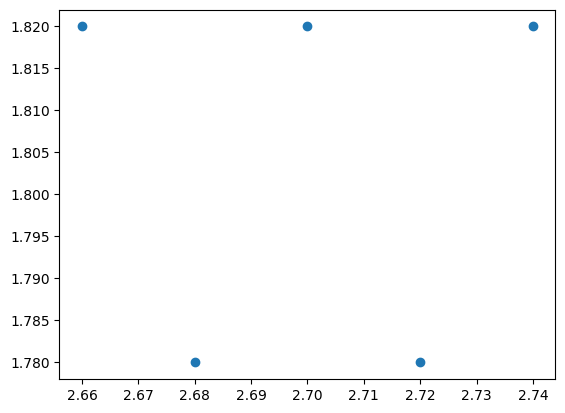

In [113]:
plt.scatter(mic_locs[0,:], mic_locs[2,:])

In [135]:
F = 513
nfft = (F-1)*2
nframes = 3

rirs = np.zeros((N,I,J,L))
rirs_dft = np.zeros((N,I,J,F,2))
for n in tqdm(range(N)):
    for i in range(I):
        for j in range(J):
            rir = data[n]['rirs'][i][j].squeeze()
            l = len(rir)
            rirs[n,i,j,:l] = rir[:l]
            
#             plt.plot(rir)
#             plt.show()
            
            RIR = lb.stft(rir, n_fft=1024)
            
#             plt.imshow(np.abs(RIR), aspect='auto')
#             plt.show()
            
            RIR = RIR[:,:3].mean(-1)
            rirs_dft[n,i,j,:,0] = RIR.real
            rirs_dft[n,i,j,:,1] = RIR.imag

100%|██████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 706.35it/s]


In [147]:
print(rirs.shape)
print(rirs_dft.shape)
print(np.min(rirs_dft[...,0]), np.max(rirs_dft[...,0]))
print(np.min(rirs_dft[...,1]), np.max(rirs_dft[...,1]))

print(grid_coords.shape)

(216, 5, 1, 2950)
(216, 5, 1, 513, 2)
-0.4584212924297835 0.5152201980992146
-0.4730528204776923 0.43865715632671526
(216, 3)


# coord-based MLP

In [162]:
train_data = (grid_coords, rirs_dft)
val_data = (grid_coords, rirs_dft)
test_data = (grid_coords, rirs_dft)
dm = DataModule(train_data, val_data, test_data)

In [163]:
dm.prepare_data()

(216, 3)
(216, 5, 1, 513, 2)
(216, 3)
(216, 5, 1, 513, 2)
(216, 3)
(216, 5, 1, 513, 2)


In [165]:
class Fourier(nn.Module):
    def __init__(self, nmb=256, scale=10):
        super(Fourier, self).__init__()
        self.b = nn.Parameter(torch.randn(2, nmb)*scale)
        self.pi = 3.14159265359

    def forward(self, x):
        x = torch.matmul(2*self.pi*x, self.b.to(x.device))
        return torch.cat([torch.sin(x), torch.cos(x)], -1)

def LinearTanh(n_in, n_out):
    # do not work with ModuleList here either.
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.Tanh()
    )
    return block
    
class RFFNet(nn.Module):
    def __init__(self, layer_dimension, f_nfeatures, f_scale, device, lam_pde=1e-4):
        super().__init__()
        
        layers = []
        num_layers = len(layer_dimension)
        
        blocks = []
        for l in range(num_layers-2):
            blocks.append(LinearTanh(layer_dimension[l], layer_dimension[l+1]))
            
        blocks.append(nn.Linear(layer_dimension[-2], layer_dimension[-1]))
        
        self.rff = Fourier(f_nfeatures, f_scale)
        self.mlp = nn.Sequential(*blocks)
    
    def forward(self, x):
        x = self.rff(x)
        x = self.mlp(x)
        x = torch.tanh(x)
        return x

In [161]:
ndim = 2
nfeatures = 256
layers = [nfeatures*2] + 4*[256] + [2]

device = 'cuda:0'

model = RFFNet(layers, nfeatures, 10, device, lam_pde=lam_pde)

max_iters = int(10e3)

from pytorch_lightning.callbacks import EarlyStopping
early_stop_callback = EarlyStopping(monitor='valid_loss')

trainer = pl.Trainer(gpus=1, 
                     check_val_every_n_epoch=200, 
                     max_epochs=max_iters, 
                     callbacks=[early_stop_callback])

trainer.fit(model, dm)

/media/diego/SSD_2/diego/Code/SteerAndInterp/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


MisconfigurationException: No `training_step()` method defined. Lightning `Trainer` expects as minimum a `training_step()`, `train_dataloader()` and `configure_optimizers()` to be defined.